***
#### About this document
_This is the assignment for the UCL CASA module Data Science for Spatial Systems (CASA0006) <br>This is a self contained Jupyter notebook with structure introduction, discussion and embeded code and bibliography._
<br>
**Code is hosted [here](https://github.com/antoniosfiala/UCL_DSSS_Final_Project)**<br>
**Data is availble [here](https://liveuclac-my.sharepoint.com/:f:/g/personal/ucfnafi_ucl_ac_uk/EpV8UnlEQQdNpu28TZHgRYoBLl-LM4iuuDGyREiLCGTEmw?e=XV5Mrz)**
***

# Multi-level segmentation of electricity consumption data: 
<p style="color:DimGray; text-align:left; font-size:20px"><i> the case of the Netherlands </i></p>
<a id="ID_title"></a>

<p style="color:DimGray; text-align:left;"><i>This paper explores data from Dutch electricity providers and establishes provider-level traits based on clustering of cities and streets they supply to. <br>It highlights the varying customer and area profiles that each serves and serves to identify potential priorities</i></p>

***

<a id="ID_intr"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore](#ID_explore) | [6.0 Analysis](#ID_analyse) | [7.0 Discussion and conclusion](#ID_conclude) | [Bibliography](#ID_biblio) | [Appendix](#ID_append) |

## 1.0 | Introduction

This paper provides outlines the method and results of an exploratory segmentation analysis of the Dutch electricity market in order to understand key differences between the types of service provided by the leading suppliers in the country. 

Using open data from the respective suppliers, this paper proposes a clustering approach to generate segments at a city and street level.

Findings at city level indicate a segregation among the suppliers along two key measures, proportion of electricity delivered to end customers (i) with smart meters and (ii) lower tariffs (as a result of off-peak use). 

To the extent possible, commentary regarding methods, data processing choices and results will be kept in the main body of the paper. Commentary accompanying the code is explanatory for the steps undertaken and a useful supplement.

### 1.1 | Requirements to run the analysis

An overview of packages used to run the analysis with brief explanation of their role.

In [103]:
# Packages for data manipulation and processing
import math
import numpy as np
import pandas as pd

# Packages for analysis
from sklearn.preprocessing import MaxAbsScaler # package to standardise data ahead of clustering
import sklearn.cluster as sk_cluster # clustering packages

# Packages for visualisation
from matplotlib import pyplot as plt # primary plotting package
import matplotlib.ticker as ticker # plt ticker manipulation
import seaborn as sns; sns.set(style="ticks", color_codes=True) # for specialised pairplot visuals

# Bespoke packages for clustering visualisation
from yellowbrick.cluster import KElbowVisualizer # testing appropriate number of clusters
from yellowbrick.cluster import intercluster_distance # interpretting distance between clusters

# Notebook settings
random_state = 42 # for reproducability
np.random.seed(random_state) # setting numpy random seed, as that is used for sklearn operations

<a id="ID_lit"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore]("#section_ID") | [6.0 Analysis](#ID_Intro) | [7.0 Results]("#section_ID") | [8.0 Discussion](#ID_Intro) | [Bibliography](#ID_Intro) | [Appendix](#ID_Intro) |

## 2.0 | Literature review

**Literature**<br>
Market segmentation has long been understood to be a key factor in setting business or government strategy (Dibb and Simkin, 2001; Piercy, 2016). It reflects the heterogenous nature of a customer or citizen and thus allows for the creation of (ideally) utility maximising approaches, be that measured in profit, or positive public good externalities. It is worth noting that this concept is separate to segmentation in the sense of decentralising monopolistic/national utility provision, the introduction of competition among providers and its effects, such as the work done by Sun et al. (2020) are not directly in scope of this work, but are useful resource for understanding the energy landscape and trade-offs made along the way.

Marketing literature breaks the process towards segmentation as follows (Kotler, 2007):
1. **S**egmenting – grouping customers based on similarities in characteristic variables
2. **T**argeting – decision-making phase on resource allocation
3. **P**ositioning – design/implementation phase of tailored marketing
<br>(STP)

Challenges are documented across all three STP elements, with case studies in the utility sector as outlined by Dibb and Simkin (2001) focusing on issues of insufficient marketing as well as data collection and analysis skills and continue to be reinforced years later through continued efforts at more accessible and automated approaches (Albert and Maasoumy, 2016; Boersma and Vos-van Gool, 2009; du Toit et al., 2016). As a results, an emphasis remains on the ‘_S_’ aspect of STP with room to either simplify or refine current segmentation approaches. Results from which both government institutions can benefit in order to better incentivise utility providers to reach goals, for instance with regards to renewable energy and smart metering, or the utilities themselves in efficiently gaining insight into their region of operation.

Understanding this element as clearly and accessibly as possibly has several potential uses, be that in estimation regional preparedness for vehicle electrification or the need to incentivise better load balancing across peak and non-peak hours in an area in order to accommodate expected increasing demand (W. Yang et al., 2017).

**Data and enquiry**<br>
Such a task can be carried out with varying arrays of datapoints, customer-specific data, household electricity demand/consumption loads as well as aggregated datapoints at an area level (Albert and Maasoumy, 2016; du Toit et al., 2016). Depending on the question at hand, consumer sociodemographic factors have been found to have marginal role as explanatory tools for behavioural choices such as tariff switching (Hille et al., 2017). The proliferation of smart metering in particular and market deregulation to some extent have resulted in greater volumes of data available in the public domain with spatial and temporal characteristics with applications from load forecasting, proposals for common data architecture schema and segmentation (Dudek, 2015; Malik et al., 2017; Rathod and Garg, 2016).

The dataset identified for this task is an amalgamation of open data from the three (formerly four) principal energy providers in the Netherlands from 2008 to 2019 (Basanisi, 2020). At its most granular level, the dataset outlines annual consumption at post code level with a number of metadata points describing aspect of the connection such as number and type of connections to the grid.

This lends the enquiry to a both point in time segmentation and temporal exploration of trends. However, in order to focus the work, understanding the current state of the country-wide usage and types of areas will be addressed first.

Therefore, this leads to the core research questions of:

    RQ1 | What segments of energy use can be observed in the Dutch market?
    RQ2 | Does the data suggest a relationship between the supplier and the segment it supplies?

This paper works to address in a repeatable and transferrable way, allowing the steps to be redeployed to other utilities or countries to gain understanding quickly. 

Finally, as the source data is available across three levels, postcode, street, city, the analysis will be run across all three to test, ease of deployment as well as test whether variance is observed across geographical levels, prompting a third research question:

    RQ3 | How do clusters vary across geographical scales?

The specific approach to achieve is outlined in the following section.

<a id="ID_method"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore](#ID_explore) | [6.0 Analysis](#ID_analyse) | [7.0 Discussion and conclusion](#ID_conclude) | [Bibliography](#ID_biblio) | [Appendix](#ID_append) |

## 3.0 | Methodology

**Method**<br>
Segmentation marketing/business terms is akin to clustering / classification in data science terminology. Approaches are broken down into unsupervised and supervised learning algorithms. 

**Supervised learning methods** are approaches that seek to infer a function or define a classifier from training data provided and are subsequently validated and tested on unseen data. The key requirement for these methods is labelled data with ‘ground truths’ against which their performance can be judged (Li et al., 2017).

**Unsupervised learning methods** represent approaches that seek to find ‘hidden features out of unlabelled data’ (Allahyari et al., 2017). No training is required for the algorithm with different approaches existing that  can be deployed on numerical and categorical features alike. 

Given the data available for this task is unlabelled, an unsupervised approach will be taken. Governder and Sivakumar (2020), outline the purpose of these techniques in the figure below.

#### 3.0 | Figure 1 | Potential use of clustering algorithms (Govender and Sivakumar, 2020)
![title](Images/Clustering_small.jpg)

One of the still very popular algorithms is K-means (Capó et al., 2017). Although, others such as a number of hierarchical exists, the advantages of K-means in fast compute times and therefore ability to handle large datasets, outlined theoretically but also in practice, are welcome traits for this study (Govender and Sivakumar, 2020). Furthermore, in line with its popularity in other fields, it is a method that sees use in similar clustering/segmentation problems in electricity field (A. Marlen et al., 2019).

In order to carry out the analysis, the below takes the reader through the process of extracting data from raw files, transforming – cleaning and aggregating – to the required resolution and load them ready for use with the clustering algorithms. Unlike hierarchical clustering, K-means required an element _K_ to be defined. _K_ denotes the number of clusters expected in the given dataset. A number of tests can be used to establish / approximate the correct number, however an assessment of the data after is required to ensure that the clusters fit into what is expected from a business or theoretical perspective.

The process will be described along the way with cell (code) outputs referred to. While reading the code itself is not necessary, it will provide additional context for the steps taken to manipulate the data. As the analysis is self-contained, there are prompts for the reader to amend and run to observe changes in outputs/reports that are generated, however these are optional. 

Lastly, for code reusability, to the extent possible code is contained within reused functions. As a result, there are segments of code with no given output that are nevertheless crucial for the functionality of later parts. 


<a id="ID_data"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore](#ID_explore) | [6.0 Analysis](#ID_analyse) | [7.0 Discussion and conclusion](#ID_conclude) | [Bibliography](#ID_biblio) | [Appendix](#ID_append) |

## 4.0 | Data gathering

The raw dataset includes data from 2008 to 2019 across gas and electricity use in the Netherlands. The below code firstly collates and summarises the available data. It is assumed that the data is kept in the same repository as it was shared, else feel free to change the base path variable `raw_file_path`. The initial analysis only requires the 2019 dataset, however the entire dataset is available for download [here](https://www.kaggle.com/lucabasa/dutch-energy).

**Pleaste note:** the datasets are published in the following format: `01.01.YYYY+1`. As a result, the year range specified in the reference variables below is for the year in which data was published. It will have values for the preceeding year.

In [116]:
# reference variables to import the relevant files
raw_file_path = "./Data/Dutch-energy/"

In [133]:
raw_energy_type = ["electricity","gas"]
# generate list of years available (years correspond to years of collection)
#raw_years_available = list(np.arange(2020,2021,1)) # import one year
raw_years_available = list(np.arange(2009,2021,1)) # import all years

**Create raw dataframe by supplier**<br>
_avoiding creating variables dynamically due to suggested instability of globals() and locals()_ [example](https://stackoverflow.com/questions/1429814/how-to-programmatically-set-a-global-module-variable)

`f_import_file` is a function that uses the reference variables above and allows for easier dataframe generation

In [135]:
def f_import_file(p_energy_supplier,p_supplier_prefix,p_report_success = False,p_report_fail = False,p_years = raw_years_available,p_energy_type = "electricity"):
    
    # function variables
    global raw_file_path
    global energy_providers
    
    df_master_all = []
    #df_years_imported = f"Import report | {p_energy_supplier.upper()} | The following years have been imported:\n"
    temp_fixed_space = 10-len(p_energy_supplier)
    temp_space_buffer = " "
    df_years_imported = f"Imported | {p_energy_supplier.upper()}{temp_fixed_space*temp_space_buffer}"
    
    # for every year try to open and save dataframe to holding variable that is returned by the function
    for year in raw_years_available:
        
        temp_file_path = f"{raw_file_path}{p_energy_type}/{p_energy_supplier}_{p_energy_type}_{p_supplier_prefix}{year}.csv"
        temp_file_name = f"{p_energy_supplier}_{p_energy_type}_{p_supplier_prefix}{year}.csv"

        try:
            temp_df = pd.read_csv(temp_file_path)
            # one is taken away from the import year - it denotes year of extraction whereas the data is for the previous year
            temp_df["Year"] = year-1
            temp_df["Supplier"] = p_energy_supplier
            df_master_all.append(temp_df)
            if p_report_success is False:
                pass
            else:
                print(f"Import success | {p_energy_supplier.upper()} | {temp_file_name} loaded")
            
            df_years_imported = df_years_imported + f"|{year}| "
            
        except FileNotFoundError:
            if p_report_fail is False:
                pass
            else:
                print(f"Import error | {p_energy_supplier.upper()} | {temp_file_name} does not exist")
            df_years_imported = df_years_imported + f"| -- | "
        except: 
            if p_report_fail is False:
                pass
            else:
                print(f"Import error | {p_energy_supplier.upper()} | {temp_file_name} experienced an uncatogerised error.")
            df_years_imported = df_years_imported + f"| -- | "
    
    # sort true in order to handle pandas error when axis between files do not perfectly align

    return_df = pd.concat(df_master_all,sort=True)

    print(df_years_imported)
    
    return return_df

Using the `f_import_file` function to search for seek to load all data within the time range specified.

In [136]:
# energy provider and file prefix
energy_providers = [("endinet","0101"),("enexis","0101"),("liander","0101"),("stedin","")]

# reporting of errors turned off, amend 'p_report_success' 'p_report_fail' to True to see more detailed reporting
df_endinet = f_import_file(energy_providers[0][0],energy_providers[0][1])
df_enexis =  f_import_file(energy_providers[1][0],energy_providers[1][1])
df_liander = f_import_file(energy_providers[2][0],energy_providers[2][1])
df_stedin =  f_import_file(energy_providers[3][0],energy_providers[3][1])

# placing all dataframes in an object for operations that affect all
df_master_raw = [df_endinet,df_enexis,df_liander,df_stedin]

Imported | ENDINET   | -- | | -- | | -- | |2011| |2012| |2013| |2014| |2015| |2016| | -- | | -- | | -- | | -- | 
Imported | ENEXIS    | -- | | -- | |2010| |2011| |2012| |2013| |2014| |2015| |2016| |2017| |2018| |2019| |2020| 
Imported | LIANDER   | -- | |2009| |2010| |2011| |2012| |2013| |2014| |2015| |2016| |2017| |2018| |2019| |2020| 
Imported | STEDIN    | -- | |2009| |2010| |2011| |2012| |2013| |2014| |2015| |2016| |2017| |2018| |2019| |2020| 


Importing of files across the four suppliers shows that between the calendar years 2016 - 2019 (files 2017 - 2020), only three principal suppliers have data available. ENDINET data is no longer available, and will therefore not be considered.

To adequately prepare the data for analysis it must be combined, understood and cleaned. The below code and description takes the reader through this process.

#### Shape 
- an inconsistency appears in **number of columns**, **error with stedin**
- varied lengths are acceptable as far as each provider covers a different number of **years and postcodes**

In [137]:
# Examine shape of each data input
for index,df in enumerate(df_master_raw):
    print(energy_providers[index][0],df.shape)

endinet (31082, 16)
enexis (1266279, 16)
liander (1655181, 16)
stedin (999434, 17)


#### Columns
Given at least one inconsistency in the number of columns, we will check whether the naming conventions of all columns align. The `endinet` dataset will be used as the baseline for comparison.

In [138]:
columns_list_comp = []

for index,df in enumerate(df_master_raw):
    # create column called as the provider
    columns_list_comp.append(list(df.columns))

# get intersections of the lists creating unique common valueset
columns_inter = set(columns_list_comp[0]).intersection(columns_list_comp[1],columns_list_comp[2],columns_list_comp[3])
columns_diff = []
columns_dfs = []
for index,col_list in enumerate(columns_list_comp):
    temp_list = col_list
    temp_list[:] = [element for element in temp_list if element not in columns_inter]
    
    if len(temp_list) == 0:
        print(f"{energy_providers[index][0]} columns all match.")
    else:
        print(f"{energy_providers[index][0]} has additional columns: {temp_list}")
        columns_diff.append(temp_list)
        columns_dfs.append(index)

endinet columns all match.
enexis columns all match.
liander columns all match.
stedin has additional columns: ['STANDAARDDEVIATIE']


Given the one outlier column, it can be dropped in order for the remaining dataset to be explored and cleaned as one. However, the code below is written to accommodate any non-matching columns that may appear in the future.

In [139]:
# dropping standardeviation column, using try/except statement in case code is not run in order
try:
    for index,df in enumerate(columns_dfs):
        df_master_raw[df].drop(columns_diff[index], axis = 1,inplace = True)
    print("Column(s) dropped successfully")
except:
    print("Column could not be dropped as it is no longer in dataframe")

Column(s) dropped successfully


**Data types**

The below allows for a cursory check of datatypes across the datafarmes. As everything matches, datafarmes can be merged.

Note, for simplicity of presentation reporting has been turned off. If you wish to see the report, please toggle the `dtype_report_results` variable.

In [140]:
dtype_report_results = False

# conditional reporting
if dtype_report_results:
    for index,df in enumerate(df_master_raw):
        print(energy_providers[index][0].upper(),"|")
        print(df.dtypes)
        print("")
else: pass

### Merging data frames

To create one consistent database for analysis, all dataframes are merged below and a reference file is saved. Please note this process can take type and has been commented out.

We can also observe that we have close to **four million records across sixteen columns**.

In [142]:
df_single_master_raw = pd.concat(df_master_raw)
print("Single dataframe shape:",df_single_master_raw.shape)
df_single_master_raw.head()

# Save merged dataframe 
path_to_save = "./Data/Processing/"
file_name = "DF_all_supplier_merged"
#df_single_master_raw.to_csv(path_to_save+file_name)

Single dataframe shape: (3951976, 16)


**Understanding the data**

In order to select the most appropriate year to start the analysis, data availability and missing values need to be assessed.

The below will present general data availability and summary statistics for the aggregate dataframe.

Firstly, looking at the proportion of missing values (in orange) across the columns indicates that data is missing from columns `delivery_perc`, `purchase_area`, `type_conn_perc` and `type_of_connection`. However, as a % of total data the amounts are negligible, except purchase area. 

As a result, **initial work will be carried on out on 2019** as a year with no missing data, before scalling it to other years.

#### 4.0 | Figure 2 | Proportion of data available across years in dataframe

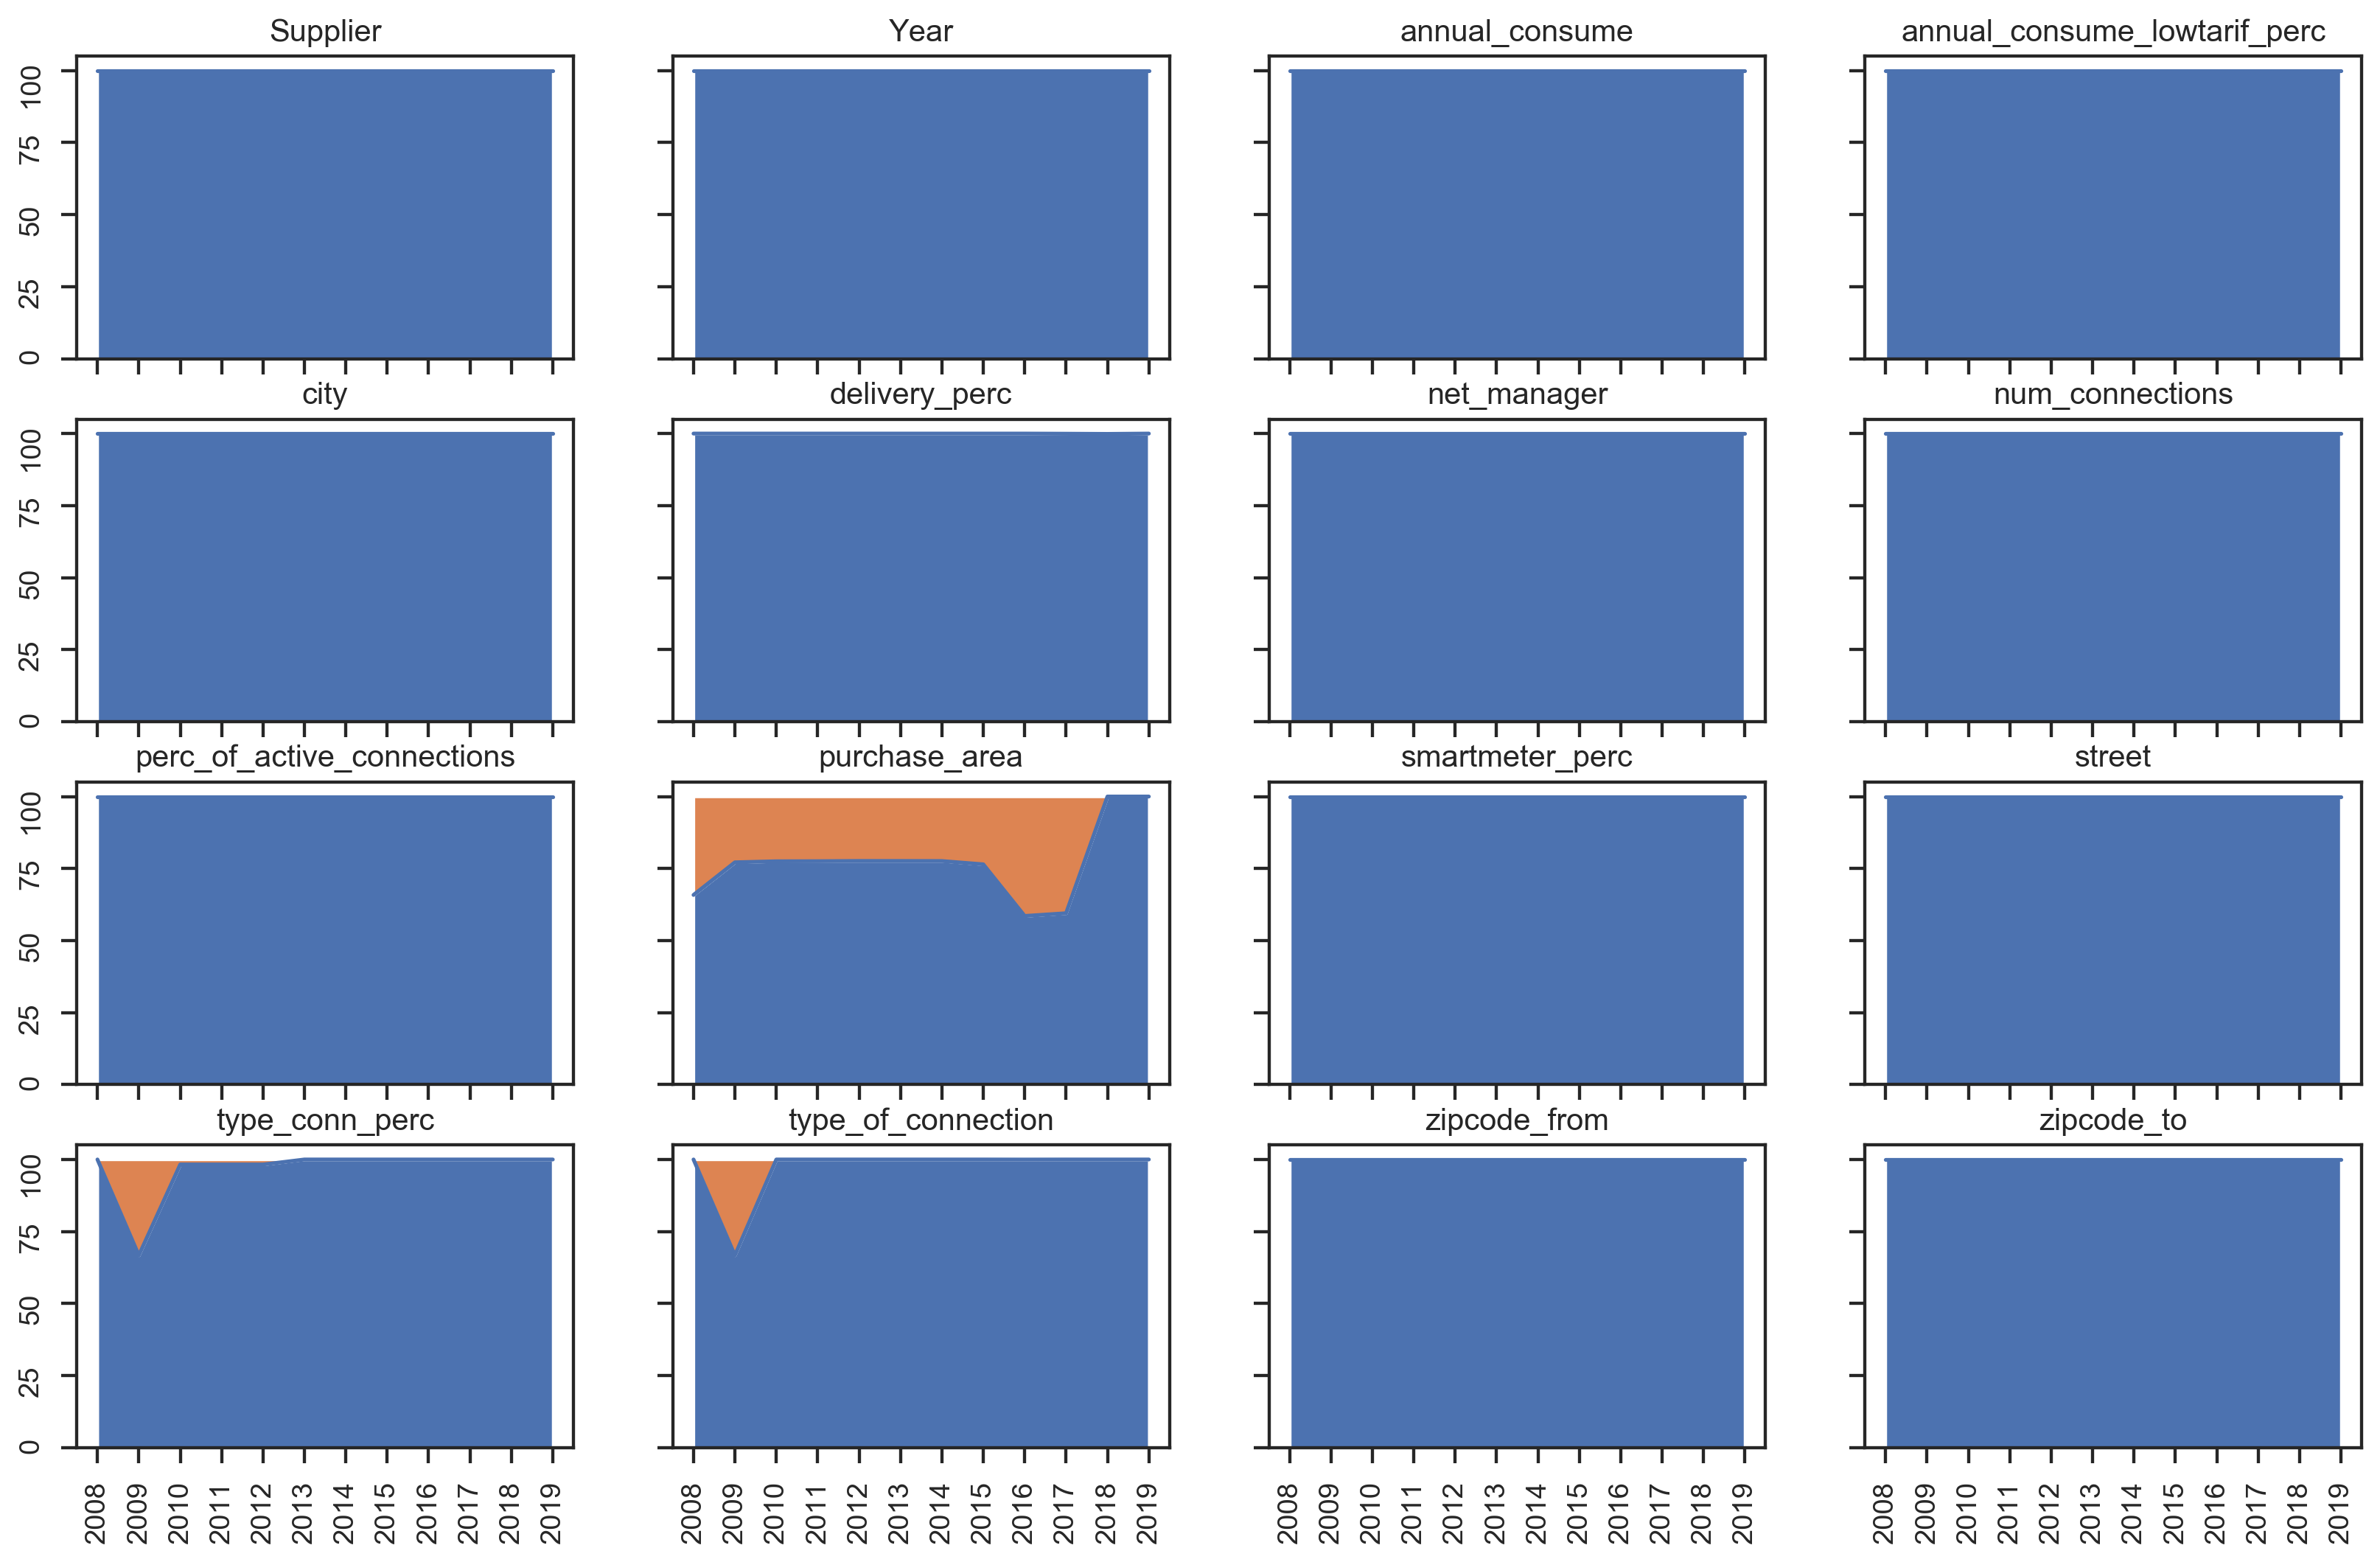

In [143]:
df_range_of_years = sorted(list(df_single_master_raw.Year.unique()))
df_missing_data = pd.DataFrame()
df_values_by_year = pd.DataFrame(index = ["df_len"])
for year in df_range_of_years:
    
    df_missing_data[year] = df_single_master_raw[df_single_master_raw.Year == year].isna().sum()/len(df_single_master_raw[df_single_master_raw.Year == year])*100
    #df_values_by_year[year] = len(df_single_master_raw[df_single_master_raw.Year == year])
    
#df_missing_data = df_missing_data.append(df_values_by_year, ignore_index=False)
df_missing_data_transposed = df_missing_data.transpose().copy()

# how many rows and columns in plot
n_row = 4
n_column = math.ceil(len(df_missing_data_transposed.columns)/n_row)
# coordinates
n_plot_coordinates = [np.arange(0,n_column,1)]*n_row

fig, axes = plt.subplots(n_row,n_column,figsize = (16,10),dpi=250,squeeze = False, sharex = True, sharey = True)

# below forloops plots missing values for every column in DF by year
plot_counter = 0
xticks = ticker.MaxNLocator(len(df_missing_data_transposed.index))

for index,entry in enumerate(n_plot_coordinates):
    
    # for every x coordinate for our subplot
    for sub_entry in entry:
        
        temp_index = list(df_missing_data_transposed.index)
        temp_series = 100-df_missing_data_transposed.iloc[:,[plot_counter]]
        axes[index][sub_entry].plot(temp_series)
        # values present
        axes[index][sub_entry].fill_between(temp_index,np.array(temp_series).flatten(),0)
        # missing values
        axes[index][sub_entry].fill_between(temp_index,np.array(temp_series).flatten(),100)
        axes[index][sub_entry].title.set_text(temp_series.columns[0])
        axes[index][sub_entry].set_ylim([0,105])
        axes[index][sub_entry].set_xlim([2007.5,2019.5])
        axes[index][sub_entry].xaxis.set_major_locator(xticks)
        axes[index][sub_entry].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
        axes[index][sub_entry].tick_params(labelrotation=90)
        plot_counter += 1

#### Unique identifier
In order to carry out segmenting of each region, we need to test that there are no duplicate values. 
The Post code identifiers `zipcode_from` and `zipcode_to` are expected to serves as unique IDs.

Counts of unique values across all columns will be checked along with a created key to assess the extent to which there are duplicates.

The created key is generated by concatenating the two postcode (zipcode) columns with the year and suppliers.

The concatenated combination, aligns with the total of records we have and can be used as an easier to understand data label as opposed to a dataframe numerical index. 

In [144]:
# Generate additional unique ID for entire dataframe
df_single_master_raw["zip_id"] = df_single_master_raw.Year.astype(str)+"_"+df_single_master_raw.Supplier +"_"+df_single_master_raw.zipcode_from + "_" + df_single_master_raw.zipcode_to

In [145]:
# Unique ID
filter_year = 2019
df_working = df_single_master_raw[df_single_master_raw.Year == filter_year].copy()

print(f"Lenght of {filter_year} dataframe is {len(df_working)}")
print(f"Checking for unique values across columns\n")
# subselect categorical columns
categorical_columns = ['Supplier', 'Year', 'city', 'net_manager', 'purchase_area', 'street', 'type_of_connection', 'zipcode_from', 'zipcode_to',"zip_id"]

# print unique values per column to understand what best serves as a unique identfier
for column in categorical_columns:
    print(f"Column | {column} | {len(df_working[column].unique())}")

Lenght of 2019 dataframe is 355101
Checking for unique values across columns

Column | Supplier | 3
Column | Year | 1
Column | city | 2388
Column | net_manager | 8
Column | purchase_area | 8
Column | street | 104360
Column | type_of_connection | 14
Column | zipcode_from | 355068
Column | zipcode_to | 355086
Column | zip_id | 355101


In [146]:
# set id as index
df_working_id = df_working.set_index("zip_id").copy()
df_working_id.head()

,Supplier,Year,annual_consume,annual_consume_lowtarif_perc,city,delivery_perc,net_manager,num_connections,perc_of_active_connections,purchase_area,smartmeter_perc,street,type_conn_perc,type_of_connection,zipcode_from,zipcode_to
zip_id,,,,,,,,,,,,,,,,
2019_enexis_4251AA_4251AA,enexis,2019,5524.52,28.41,WERKENDAM,97.62,Enexis B.V.,42.0,100.0,ENEXIS,11.90,Sasdijk,50.00,3x25,4251AA,4251AA
2019_enexis_4251AB_4251AB,enexis,2019,4022.88,35.36,WERKENDAM,94.12,Enexis B.V.,17.0,100.0,ENEXIS,47.06,Sasdijk,41.18,1x25,4251AB,4251AB
2019_enexis_4251AC_4251AC,enexis,2019,2505.27,32.82,WERKENDAM,81.82,Enexis B.V.,11.0,100.0,ENEXIS,36.36,Sasdijk,63.64,1x25,4251AC,4251AC
2019_enexis_4251AD_4251AD,enexis,2019,4595.36,34.92,WERKENDAM,96.43,Enexis B.V.,28.0,100.0,ENEXIS,28.57,Sasdijk,39.29,3x25,4251AD,4251AD
2019_enexis_4251AE_4251AG,enexis,2019,5004.71,61.92,WERKENDAM,90.48,Enexis B.V.,21.0,100.0,ENEXIS,38.10,Heuveltje,42.86,1x25,4251AE,4251AG


#### Focusing and splitting the dataframe
With unique identifiers established from the raw data, a selection of measures of categorical values can be made. As the focus is to segment the performance, columns deemed helpful to that will be retained. Values not carried forward will remain in a reference table.

| Column             | Type       | Description                                                                     |
|--------------------|------------|---------------------------------------------------------------------------------|
| Supplier           | Part of ID - move to reference table | Supplier of electricity, already part of ID, will be in index                                     |
| Year               | Part of ID - move to reference table | Year of datapoint, already part of ID, will be in index                                           |
| city               | Aggregating category - retain  | City of post code, not required right now                                       |
| net_manager        | Move to reference table  | Network manager, which may differ from supplier, however not required right now |
| purchase area      | Move to reference table  | Not required right now                                                          |
| Street             | Aggregating category - retain  | Not required right now, may be of use for data aggregation                      |
| Type of connection | Move to reference table  | Not required right now                                                          |
| zipcode_from       | Part of ID - move to reference table| Starting point for area referenced, will be in index                                              |
| zipcode_to         | Part of ID - move to reference table| Starting point for area referenced, will be in index                                             |
| annual_consume               | Measure   | consumption of power                                          |
| annual_consume_lowtarif_perc | % Measure | Year of datapoint, already part of ID                         |
| delivery_perc                | Move to reference table | Electricity % delivered by the named supplier/network manager |
| num_connections              | Measure   | Number of connections of that supplier supplier               |
| perc_of_active_connections   | % Measure | % of active connections                                       |
| smartmeter_perc              | % Measure | % of smart meter connections                                  |
| type_conn_perc               | Move to reference table | % of connection of the 'type_of_connection' connection - move to reference       |

The code below, separates out the dataframed for the year 2019, into its reference and analysis components.
Moving forward the 'df_working_analyse' dataframe will be used. A copy will be saved for reference purposes, uncomment if you wish to save the file.

In [147]:
# reference columns for filtering
#columns_reference = ["Supplier","Year","city","net_manager","purchase_area","street","type_of_connection","type_conn_perc","zipcode_from","zipcode_to"]
# version that retains street and city
columns_reference = ["Supplier","Year","net_manager","purchase_area","type_of_connection","type_conn_perc","zipcode_from","zipcode_to","delivery_perc"]
columns_both = ["city","street"]
columns_to_segment_on = [element for element in list(df_working_id.columns) if element not in columns_reference]

# split data
df_working_reference = df_working_id.loc[:,columns_reference+columns_both].copy()
df_working_analyse = df_working_id.loc[:,columns_to_segment_on].copy()

In [149]:
# Preview of the remaining table and its columns
df_working_analyse.head()

# Save merged dataframe 
path_to_save = "./Data/Processing/"
file_name = "DF_2019_analysis"
df_working_analyse.to_csv(path_to_save+file_name)

Summary statistics of the remaining dataframe can be seen below. Large vartions as measured by standard deviation can be observed. A historgram plot below shows the distribution across all points.

In [153]:
df_working_analyse.describe()

,annual_consume,annual_consume_lowtarif_perc,num_connections,perc_of_active_connections,smartmeter_perc
count,355101.000000,355101.000000,355101.000000,355101.000000,355101.000000
mean,4141.411398,71.174168,23.389027,96.202254,73.225418
std,3544.708573,23.902468,16.657029,10.618985,23.565324
min,0.000000,0.000000,9.000000,0.000000,0.000000
25%,2449.000000,50.000000,15.000000,96.970000,63.640000
50%,3122.000000,75.000000,20.000000,100.000000,80.000000
75%,4249.440000,94.440000,26.000000,100.000000,90.480000
max,65348.800000,100.000000,1044.000000,100.000000,100.000000


#### 4.0 | Figure 3 | Data distribution at post-code level

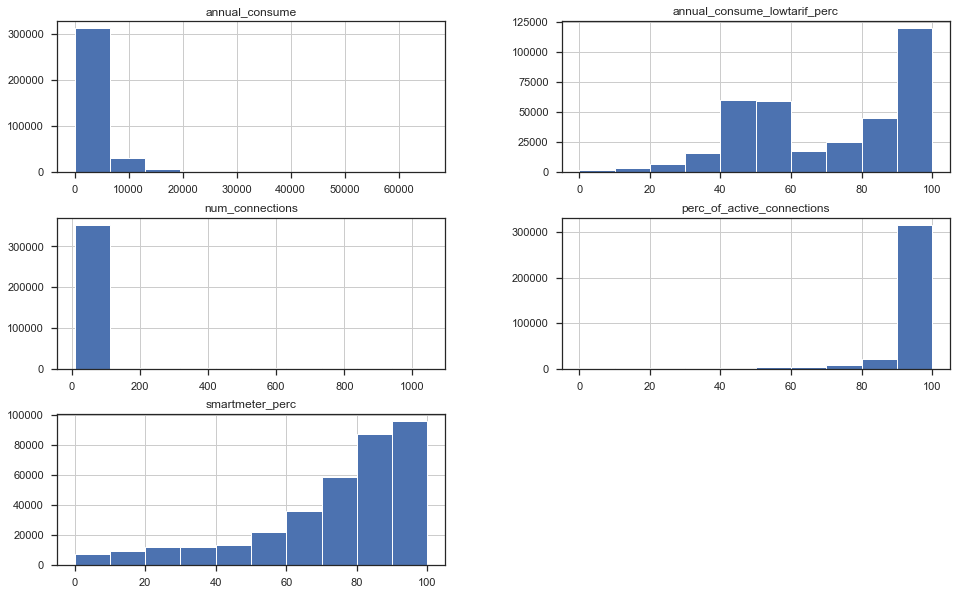

In [154]:
df_analyse_histograms = df_working_analyse.hist(figsize = (16,10))

<a id="ID_explore"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore](#ID_explore) | [6.0 Analysis](#ID_analyse) | [7.0 Discussion and conclusion](#ID_conclude) | [Bibliography](#ID_biblio) | [Appendix](#ID_append) |

## 5.0 | Data preparation

With 2019 selected as the year with no missing values. The next stage prepares the data for aggregation to different spatial scales in order to carry out comparative clustering analysis.

The key challenge and the problem solved by function `f_group_by_category` is the different aggregation methods required for columns with absolute values and those with percentages which need to be added and recalculated respectively. To that end, the function calculates new fields and generates a new dataframe at the spatial level defined by parameter `p_group_key`.

In [155]:
def f_group_by_category(p_df, p_group_key, p_col_ref,p_precent_col_only = False):
    
    temp_col_percent = []
    temp_col_abs = []
    temp_col_base = []
    
    for entry in p_col_ref:
        temp_col_percent.append(entry[0])
        temp_col_abs.append(entry[1])
        temp_col_base.append(entry[2])
        
    # calculate absolute columns by cycling through reference lists    
    for index,entry in enumerate(temp_col_abs):
        p_df[entry] = p_df[temp_col_base[index]] * p_df[temp_col_percent[index]] / 100
    
    # group by dataframe and drop incorrect columns
    temp_df = p_df.groupby(by = p_group_key).sum().drop(temp_col_percent,axis = 1).copy()
    
    # calculate new % columns by cycling through reference lists    
    for index,entry in enumerate(temp_col_percent):
        temp_df[entry] = temp_df[temp_col_abs[index]] / temp_df[temp_col_base[index]] * 100
    
    if p_precent_col_only is True:
        temp_df.drop(temp_col_abs+temp_col_base,axis = 1,inplace = True)
    elif p_precent_col_only == "some":
        temp_df.drop(temp_col_abs,axis = 1,inplace = True)
    else:
        pass
    
    return temp_df

Two dataframes are generated:

1. City level
2. Street level

In [161]:
# Set out columns in this order 
#(percentages - recalculated || absolutes - to be created || base values - base on which previous two are calculated)

group_by_columns_ref = [("perc_of_active_connections","active_connections","num_connections"),
                        ("smartmeter_perc","smart_connections","num_connections"),
                        ("annual_consume_lowtarif_perc","annual_consume_lowtarif","annual_consume")]

# create summarised dataframes
df_working_city = f_group_by_category(df_working_analyse,"city",group_by_columns_ref,p_precent_col_only = True)
df_working_street = f_group_by_category(df_working_analyse,"street",group_by_columns_ref,p_precent_col_only = True)

To understand each new dataframe, the SNS package is used generate distribution and correlation plots for all variables.

#### 5.0 | Figure 4 | City level dataframe visualisation

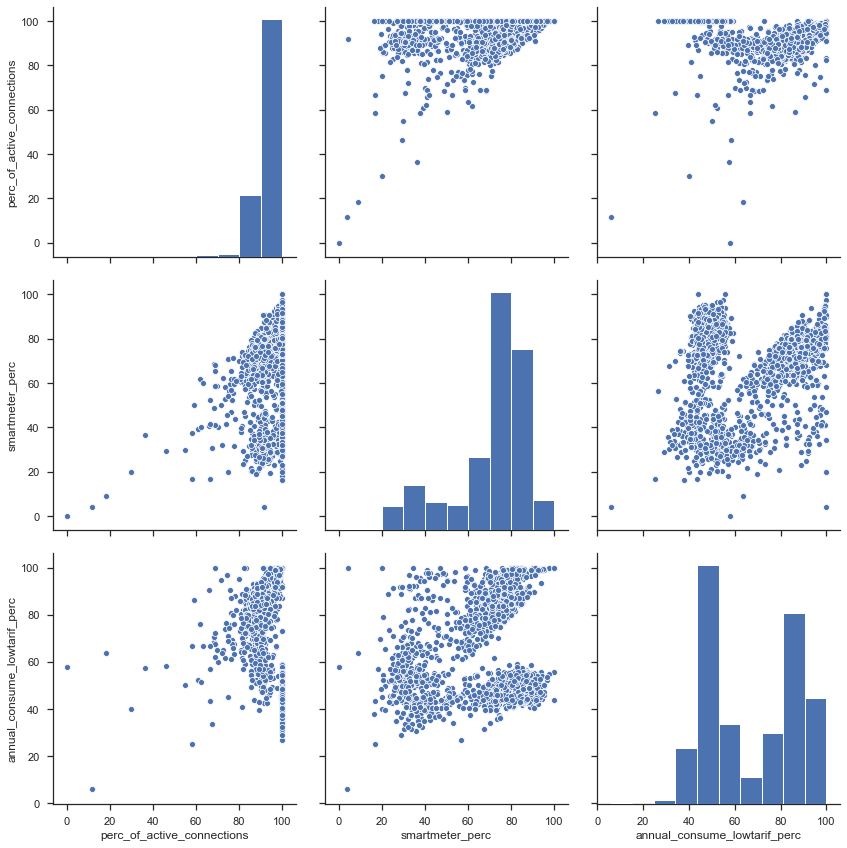

In [165]:
plot_sns_city = sns.pairplot(df_working_city,height = 4)

A cursory look at the correlation plots of the respective percentage variables and their distributions suggests potential clusters, 2 or 3 depending on the plot. This is an encouraging sign as it suggests that there are indeed cities which fall into disperate categories.

#### 5.0 | Figure 5 | Street level dataframe visualisation

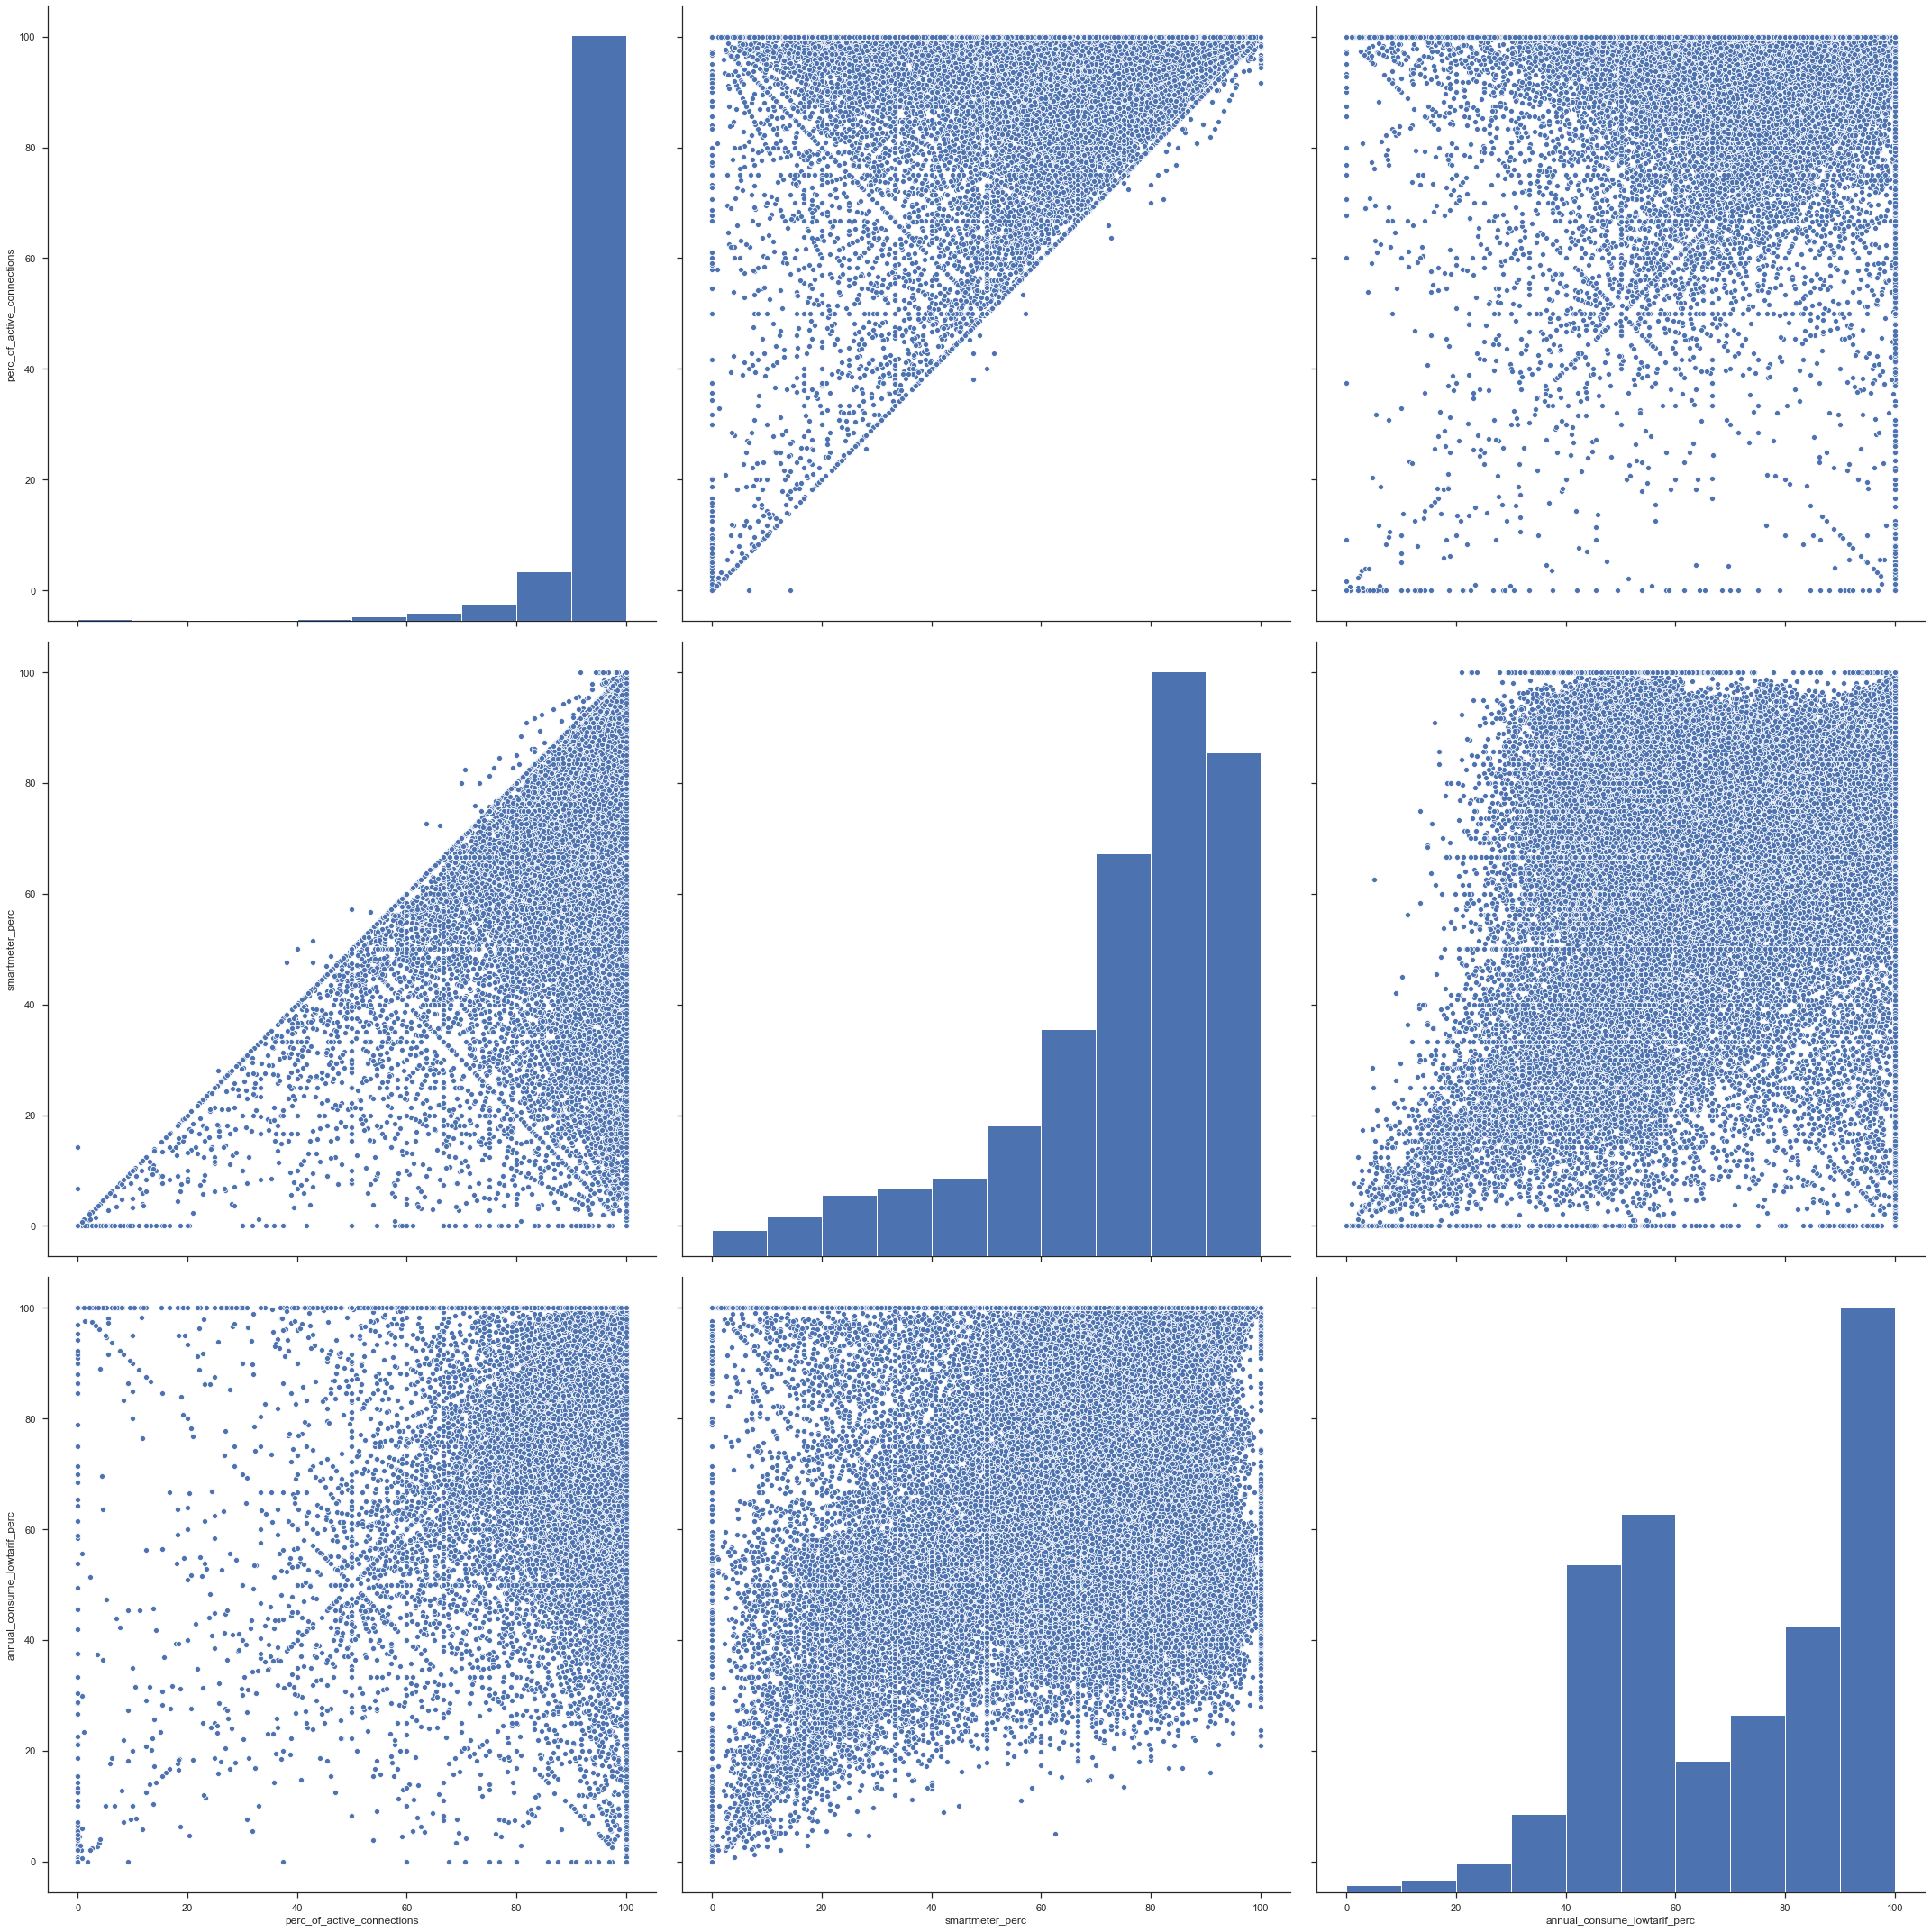

In [160]:
# plotting at large scale in order to see the detail
plot_sns_street = sns.pairplot(df_working_street,height = 10)

In contrast to the city level visualisation, Figure 5 is more challenging to visually interpret due to the volume of information. It is of note that the respective histograms for each variable follow comparable distributions to that of the city and the post-code level.

`Percentage of active connections` is significantly skewed to the right as most areas, understandably have active connections. The implication of this on the segmentation itself is not yet clear, however, it does speak to the potential need to standardise the data, as despite the same units across all measures, values that are significanly larger in size can skew the formation of clusters.

`Percentage of smart meter connections` varies somewhat more from one geographical level to the next. At the postcode and street level, a much steadier, albeit right-skewed distribution was observed whereas cities present a smaller peak at the lower end of the distribution space. This is yet another clue that this may be a key factor in segmenting the areas.

Having appropriately transformed data into their respective dataframes, section 6 will carry final data transformation, cluster number selection and presentation of results by geographical level.

<a id="ID_analyse"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore](#ID_explore) | [6.0 Analysis](#ID_analyse) | [7.0 Discussion and conclusion](#ID_conclude) | [Bibliography](#ID_biblio) | [Appendix](#ID_append) |

## 6.0 | Analysis

In order to appropriately analyse the data three things are required:

1. Selection of the appropriate numner of clusters
2. Carrying out fo the clustering and mapping the generated labels to the input dataset
3. Visualising the results to be interpretable

The below code lays out functions and code to carry out all three steps.

In [167]:
# code to carry out testing for ideal number of clusters, it returns the number of k-values
def f_cluster_testing(p_model,p_data,p_tests):
    
    k_values = []
    
    for index,test in enumerate(p_tests):
        model_1_tests = KElbowVisualizer(p_model, metric = test)
        model_1_tests.fit(p_data)
        model_1_tests.show()
        k_values.append(model_1_tests.elbow_value_)
    
    return k_values

### Clustering cities

Typically, the ideal k value is derived from an elbow plot, represented by the distortion test below. 
Additional tests, include a silhouette test and a calinski harabasz test were used. Each test a different aspect of the cluster and in unison can be used to triangulate the mathetically most sensible number of K. However, these must be interpreted. 

Furthermore, fully utilising the yellowbrick package and its features, a size/distance plot of the respective clusters is generated to understand the extent to which there are overlaps. This helps with the qualitative assessment of the clusters ahead of final comparisons.

#### 6.0 | Figure 6 | Clustering cities

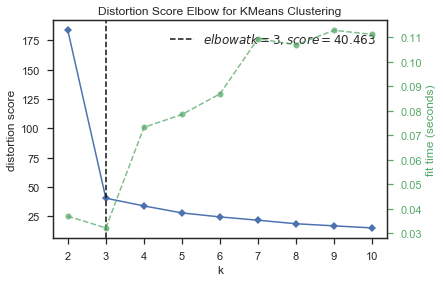

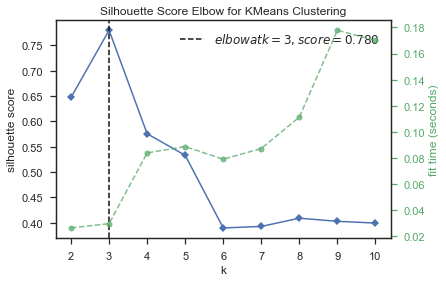

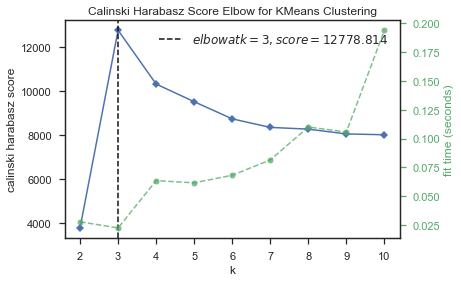

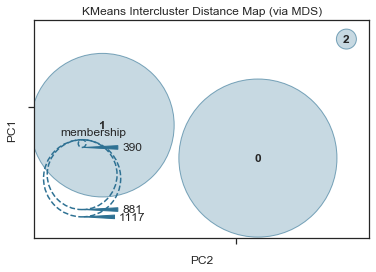

,perc_of_active_connections,smartmeter_perc,annual_consume_lowtarif_perc,kmeans_labels
city,,,,
'S GRAVENMOER,100.000000,86.386366,51.429481,1
'S-GRAVELAND,87.398841,60.684909,67.124542,0
'S-GRAVENDEEL,98.396251,94.537352,99.171036,0
'S-GRAVENHAGE,96.788010,54.984376,81.334895,0
'S-HEERENBERG,91.685224,77.961614,78.517002,0


In [169]:
# Cluster cities
cluster_tests = ["distortion","silhouette","calinski_harabasz"]
cluster_transformer = MaxAbsScaler().fit(df_working_city)
df_working_city_transformed = cluster_transformer.transform(df_working_city)

# Execute tuned clustering
cluster_models = sk_cluster.KMeans()
city_cluster_test = f_cluster_testing(p_model= cluster_models,p_data = df_working_city_transformed, p_tests = cluster_tests)
intercluster_distance(sk_cluster.KMeans(city_cluster_test[0]), df_working_city_transformed)

# map cluster back to DF
chosen_model = sk_cluster.KMeans(city_cluster_test[0])
chosen_model.fit(df_working_city_transformed)
len(chosen_model.labels_)

df_working_city["kmeans_labels"] = chosen_model.labels_
df_working_city.head()

All three tests indicate that three is the ideal number of clusters. The intercluster distance map suggests sufficient distance between each cluster although it must be noted that clusters 1 and 0 may have overlaps due to their proximity.

### Clustering streets

Following the same methodology laid out for cities, streets are clustered using the same approach. One key difference is the use of only the distortion test in response to the size of the dataset.

#### 6.0 | Figure 7 | Clustering streets

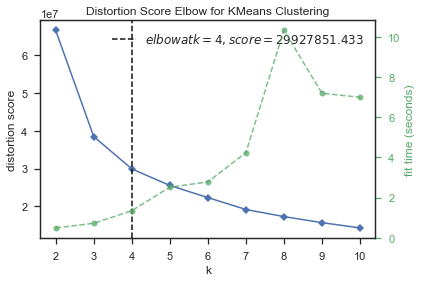

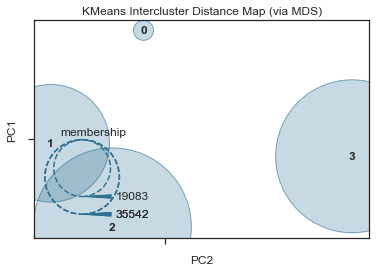

,perc_of_active_connections,smartmeter_perc,annual_consume_lowtarif_perc,kmeans_labels
street,,,,
Larikslaan,100.00,33.330000,44.400000,2
'n Tip,100.00,93.328833,44.193629,1
's Gravenlust,94.44,66.670000,77.780000,3
's Gravenweg,92.31,84.620000,100.000000,0
's Gravesandestraat,100.00,90.697209,64.258133,1


In [170]:
# Cluster cities
cluster_tests = ["distortion"]

# Execute tuned clustering
cluster_models = sk_cluster.KMeans()
city_cluster_test = f_cluster_testing(p_model= cluster_models,p_data = df_working_street, p_tests = cluster_tests)
intercluster_distance(sk_cluster.KMeans(city_cluster_test[0]), df_working_street)

# map cluster back to DF
chosen_model = sk_cluster.KMeans(city_cluster_test[0])
chosen_model.fit(df_working_street)

df_working_street["kmeans_labels"] = chosen_model.labels_
df_working_street.head()

In contrast to the cities, four categories have been identified.

### Clustering postcode areas




Finally, postcodes are clustered along the lines as streets, owing to their greater number, only the distortion test is used to identify the 'elbow' point and pass that variable on to the `KMeans()` for execution.

In [172]:
df_working_analyse_postcode = df_working_analyse.loc[:,["perc_of_active_connections","smartmeter_perc","annual_consume_lowtarif_perc"]]

#### 6.0 | Figure 8 | Clustering post codes

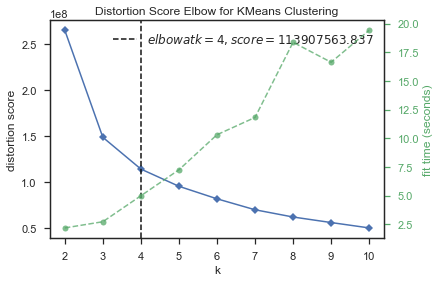

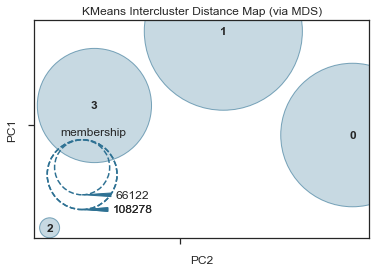

,perc_of_active_connections,smartmeter_perc,annual_consume_lowtarif_perc,kmeans_labels
zip_id,,,,
2019_enexis_4251AA_4251AA,100.0,11.90,28.41,3
2019_enexis_4251AB_4251AB,100.0,47.06,35.36,3
2019_enexis_4251AC_4251AC,100.0,36.36,32.82,3
2019_enexis_4251AD_4251AD,100.0,28.57,34.92,3
2019_enexis_4251AE_4251AG,100.0,38.10,61.92,2


In [178]:
# Cluster postcodes
cluster_tests = ["distortion"]

# Execute tuned clustering
cluster_models = sk_cluster.KMeans()
city_cluster_test = f_cluster_testing(p_model= cluster_models,p_data = df_working_analyse_postcode, p_tests = cluster_tests)
intercluster_distance(sk_cluster.KMeans(city_cluster_test[0]), df_working_analyse_postcode)

# map cluster back to DF
chosen_model = sk_cluster.KMeans(city_cluster_test[0])
chosen_model.fit(df_working_analyse_postcode)

df_working_analyse_postcode["kmeans_labels"] = chosen_model.labels_
df_working_analyse_postcode.head()

Similarly to streets, postcodes return four distinct clusters, albeit with certain overlaps between clusters 0 and 2.

To interpret each cluster in turn, they will be visualised below.

### Visualise clusters

In order to interpret the clusters, two functions were cosntructed.

`f_cluster_visualise` with the purpose of:
1. Laying out the subplots
2. Logging nominal variables as required

A second function, `f_cluster_summarise` with the purpose of saving summary statistics in a variable

In [173]:
def f_cluster_visualise(p_labelled_df,p_vis_rows,p_log_columns,p_log = False):
    
     # Rules
    columns_to_log = p_log_columns
    log = p_log
    df_working_city = p_labelled_df.copy()

    # Visualise
    plots_total_number = df_working_city.shape[1]
    plots_per_row = p_vis_rows
    plots_per_column = math.ceil(plots_total_number/plots_per_row)

    plots_row_coordinates = list(np.arange(0,plots_per_row,1)) * plots_per_column
    plots_row_coordinates = plots_row_coordinates[:plots_total_number]

    plots_column_coordinates = sorted(list(np.arange(0,plots_per_column,1)) * plots_per_row)

    fig, axes = plt.subplots(plots_per_row,plots_per_column,figsize = (16,6))

    for index,column in enumerate(list(df_working_city.columns)):

        ax_assign = axes[plots_row_coordinates[index]][plots_column_coordinates[index]]

        for value in list(df_working_city.kmeans_labels.unique()):

            if log is True:

                if column in columns_to_log:
                    # split dataframe into the number of clusters and visualise
                    df1 = df_working_city[df_working_city.kmeans_labels == value]
                    np.log(df1[column]).hist(ax = ax_assign, alpha = 0.3,label = f"Cluster {value}")
                    ax_assign.title.set_text(f"{column} (log)")
                    ax_assign.legend()

                else:
                    df1 = df_working_city[df_working_city.kmeans_labels == value]
                    df1[column].hist(ax = ax_assign, alpha = 0.3,label = f"Cluster {value}")
                    ax_assign.title.set_text(column)
                    ax_assign.legend()
            else:
                df1 = df_working_city[df_working_city.kmeans_labels == value]
                df1[column].hist(ax = ax_assign, alpha = 0.3,label = f"Cluster {value}")
                ax_assign.title.set_text(column)
                ax_assign.legend(loc = "upper right")

    plt.tight_layout()

In [174]:
def f_cluster_summarise(p_labelled_df):
    
    summary_list = []
    
    for value in list(p_labelled_df.kmeans_labels.unique()):

        # split dataframe into the number of clusters to summarise
        df1 = p_labelled_df[p_labelled_df.kmeans_labels == value]
        df1_summary = df1.describe()
        
        summary_list.append(df1_summary)
        
    return summary_list    

Examining the three city clusters visually, we can see the pattern emerging.

No cluster is particularly characterised by unusual nominal consumption or connection numbers. Instead, cluster 1 is characterised by high-frequencies of low penetration for low tarif energy use, alongside higher levels of smart meter use.

In contrast, cluster 2 is demonstrating low levels of smart meter use which coincides with low levels of low tarif energy usage.

The final cluster, cluster 0 is the one that exhibits desirable traits from a government and supplier perspective as smart meters are prevelant and customers mainly utilise the low tariff energy rates helping balance demand load.

#### 6.0 | Figure 9 | Distributions of each city cluster

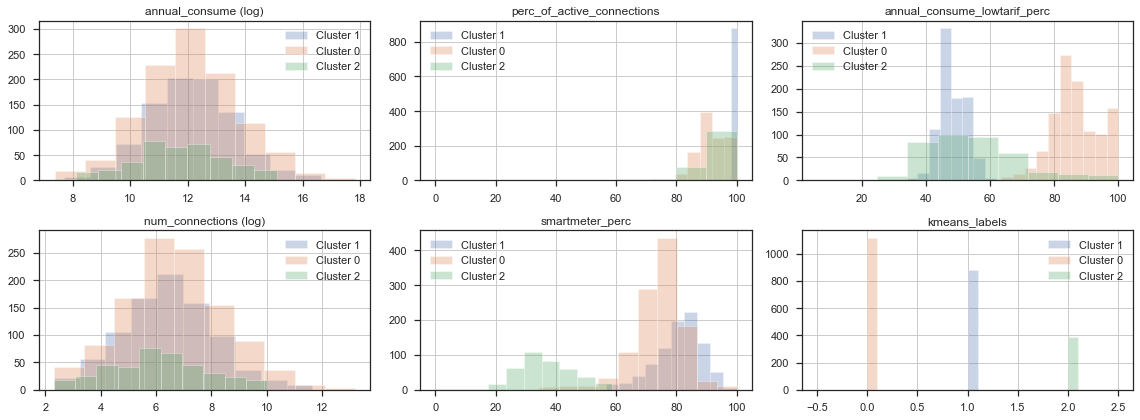

In [26]:
# city level summaries
columns_to_log = ["annual_consume","num_connections"]
f_cluster_visualise(df_working_city,2,columns_to_log,p_log = True)
df_city_summaries = f_cluster_summarise(df_working_city)

#### 6.0 | Figure 10 | Distributions of each street and post code clusters

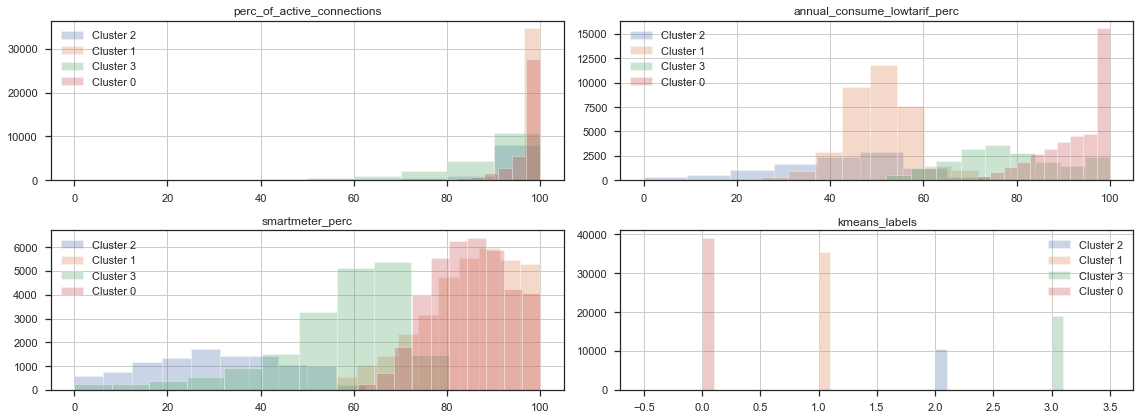

In [176]:
# street level summaries
columns_to_log = ["annual_consume","num_connections"]
f_cluster_visualise(df_working_street,2,columns_to_log,p_log = True)
df_street_summaries = f_cluster_summarise(df_working_street)

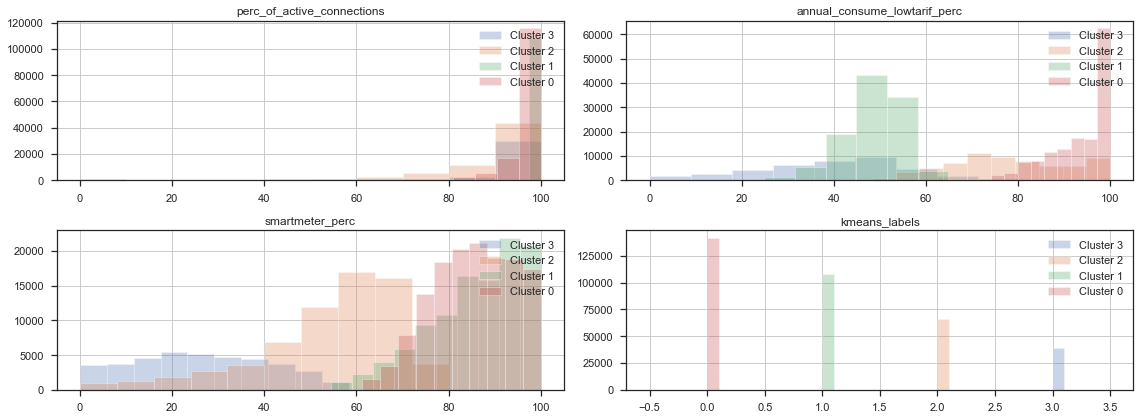

In [179]:
# visualise postcodes
columns_to_log = ["annual_consume","num_connections"]
f_cluster_visualise(df_working_analyse_postcode,2,columns_to_log,p_log = False)
df_city_summaries = f_cluster_summarise(df_working_city)

Both street level and postcode level clustering suggested four groups. The figrues above, suggest that their characteristics are similar.

- Cluster 0: as with the city cluster 0, both street and post-codes depict the high-high traits of high use of low tariff energy and high installation rates of smart meters.

- Cluster 1: aligned with cluster 2 in the city analysis - cluster 1 for street and postcode level exhibits the low-high behaviour. i.e. low levels of low tariff consumption and high levels of smart meters.

Subsequently, clusters 2 and 3 represent gradually decreasing trends across the low tariff and smart emter dimensions.

Consequence of understanding like this can be not only cities that require greater incentivation to use into smart meters (city cluster 2) but then subsequently specific streets or post-codes.

### Provider breakdown

An additional analysis at city level reveals that each supplier has a greater porpensity to operate in different types of cluster.

In [181]:
# list of all cities by supplier for 2019

df_supplier_city_list = []

for supplier in list(df_working_reference.Supplier.unique()):
    
    temp_array = df_working_reference[(df_working_reference.Supplier == supplier) & (df_working_reference.Year == 2019)].loc[:,["city"]].city.unique()
    temp_df = pd.DataFrame(index = temp_array)
    temp_df = temp_df.merge(df_working_city,left_index = True, right_index = True)
    temp_df[supplier] = 1
    df_supplier_city_list.append(temp_df)
    print(f"Report on | {supplier}")
    print(temp_df.kmeans_labels.value_counts())
    print("")

Report on | enexis
1    880
2    178
0      8
Name: kmeans_labels, dtype: int64

Report on | liander
0    896
2    201
1      8
Name: kmeans_labels, dtype: int64

Report on | stedin
0    250
2     18
Name: kmeans_labels, dtype: int64



As the output above shows, stedin, the smallest supplier by count of cities is nonetheless dominated by the higher performing cluster 0, followed by Liander who have a high number of cities in their jurisdiction and while more than 80% are in cluster 0 a ~ 20% are in cluster 2 suggesting targeting those areas can help.

Enexis is the in-between supplier with a mixture but effectively dominating the cluster 1 with only 8 cluster 1 cities falling under Liander.


<a id="ID_conclude"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore](#ID_explore) | [6.0 Analysis](#ID_analyse) | [7.0 Discussion and conclusion](#ID_conclude) | [Bibliography](#ID_biblio) | [Appendix](#ID_append) |

## 7.0 | Discussion and conclusion

In conclusion, this paper has carried clustering of electricity usage data across the Netherlands with the aim of answering the following research questions with each addressed below:

    RQ1 | What segments of energy use can be observed in the Dutch market?
    RQ2 | Does the data suggest a relationship between the supplier and the segment it supplies?
    RQ3 | How do clusters vary across geographical scales?


**RQ3**: Some variation can be observed across the levels, with clustering at city level yielding three clusters whereas street and postcode level analysis suggests four is the appropriate number.

**RQ1**: Along the measures available, categorise were observed that were chiefly defined by variation in smart-meter and low-tariff use that appear to correspond to the supplier they fall under.

**RQ2**: Building on RQ1 it appears that there may be a relationship between the supplier and the extent to which smart meters are used. 

The implication of this is that both at institutional, governmental level and supplier level, there may be room to improve targetting to transition the remaining areas to smart metering.

<a id="ID_biblio"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore](#ID_explore) | [6.0 Analysis](#ID_analyse) | [7.0 Discussion and conclusion](#ID_conclude) | [Bibliography](#ID_biblio) | [Appendix](#ID_append) |


***
## Bibliography

 

A. Marlen, A. Maxim, I. A. Ukaegbu, H. S. V. S. Kumar Nunna, 2019. Application of Big Data in Smart Grids: Energy Analytics, in: 2019 21st International Conference on Advanced Communication Technology (ICACT). Presented at the 2019 21st International Conference on Advanced Communication Technology (ICACT), pp. 402–407. https://doi.org/10.23919/ICACT.2019.8701973


Albert, A., Maasoumy, M., 2016. Predictive segmentation of energy consumers. Appl. Energy 177, 435–448. https://doi.org/10.1016/j.apenergy.2016.05.128


Allahyari, M., Pouriyeh, S., Assefi, M., Safaei, S., Trippe, E.D., Gutierrez, J.B., Kochut, K., 2017. A brief survey of text mining: Classification, clustering and extraction techniques. ArXiv Prepr. ArXiv170702919.


Basanisi, L., 2020. Energy consumption of the Netherlands [WWW Document]. kaggle.com. URL https://www.kaggle.com/lucabasa/dutch-energy/metadata (accessed 4.30.20).


Boersma, M., Vos-van Gool, M., 2009. Customer Segmentation in the Utility Industry, in: Bausch, A., 


Schwenker, B. (Eds.), Handbook Utility Management. Springer Berlin Heidelberg, Berlin, Heidelberg, pp. 559–574. https://doi.org/10.1007/978-3-540-79349-6_33


Capó, M., Pérez, A., Lozano, J.A., 2017. An efficient approximation to the K-means clustering for massive data. Knowl.-Based Syst. 117, 56–69.


Dibb, S., Simkin, L., 2001. Market Segmentation: Diagnosing and Treating the Barriers. Ind. Mark. Manag. 30, 609–625. https://doi.org/10.1016/S0019-8501(99)00127-3


du Toit, J., Davimes, R., Mohamed, A., Patel, K., Nye, J., 2016. Customer segmentation using unsupervised learning on daily energy load profiles. J. Adv. Inf. Technol. Vol 7.


Dudek, G., 2015. Short-term load forecasting using random forests, in: Intelligent Systems’ 2014. Springer, pp. 821–828.


Govender, P., Sivakumar, V., 2020. Application of k-means and hierarchical clustering techniques for analysis of air pollution: A review (1980–2019). Atmospheric Pollut. Res. 11, 40–56. https://doi.org/10.1016/j.apr.2019.09.009


Hille, S.L., Tabi, A., Wüstenhagen, R., 2017. Market Segmentation for Green Electricity Marketing Results of a Choice-Based Conjoint Analysis with German Electricity Consumers, in: Herbes, C., Friege, C. (Eds.), Marketing Renewable Energy: Concepts, Business Models and Cases. Springer International Publishing, Cham, pp. 91–108. https://doi.org/10.1007/978-3-319-46427-5_5


Kotler, P., 2007. Marketing management. Pearson Italia Spa.


Li, T., Yi, X., Carmanis, C., Ravikumar, P., 2017. Minimax gaussian classification & clustering. Presented at the Artificial Intelligence and Statistics, pp. 1–9.


Malik, M., Tabone, M., Chassin, D.P., Kara, E.C., Guha, R.V., Kiliccote, S., 2017. A common data architecture for energy data analytics. Presented at the 2017 IEEE International Conference on Smart Grid Communications (SmartGridComm), IEEE, pp. 417–422.


Piercy, N.F., 2016. Market-led strategic change: Transforming the process of going to market. Taylor & Francis.


Rathod, R.R., Garg, R.D., 2016. Regional electricity consumption analysis for consumers using data mining techniques and consumer meter reading data. Int. J. Electr. Power Energy Syst. 78, 368–374. https://doi.org/10.1016/j.ijepes.2015.11.110


Sun, X., Zhou, X., Chen, Z., Yang, Y., 2020. Environmental efficiency of electric power industry, market segmentation and technological innovation: Empirical evidence from China. Sci. Total Environ. 706, 135749. https://doi.org/10.1016/j.scitotenv.2019.135749


W. Yang, Z. Yan, H. Xinyang, L. Yangjia, Y. Jun, R. Yingqing, 2017. Prediction of electric vehicle market based on market segmentation and regional gradient development, in: 2017 IEEE Conference on Energy Internet and Energy System Integration (EI2). Presented at the 2017 IEEE Conference on Energy Internet and Energy System Integration (EI2), pp. 1–5. https://doi.org/10.1109/EI2.2017.8245313

***

<a id="ID_append"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore](#ID_explore) | [6.0 Analysis](#ID_analyse) | [7.0 Discussion and conclusion](#ID_conclude) | [Bibliography](#ID_biblio) | [Appendix](#ID_append) |

## Appendix

Link to the original raw data can be found [here](https://www.kaggle.com/lucabasa/dutch-energy).

Link to the UCL hosted raw data can be found in one drive, [here](https://liveuclac-my.sharepoint.com/:f:/g/personal/ucfnafi_ucl_ac_uk/EpV8UnlEQQdNpu28TZHgRYoBLl-LM4iuuDGyREiLCGTEmw?e=XV5Mrz)